# Project: Customer Segmentation with Clustering

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.


### Core Concepts:
1.  **Unsupervised Learning:** Understanding the difference between supervised and unsupervised learning.
2.  **Clustering Fundamentals & K-Means:** A deep dive into how the K-Means algorithm works.
3.  **The Elbow Method:** A critical technique for finding the optimal number of clusters (`k`).
4.  **Multi-dimensional EDA:** Exploring relationships between all features using 2D and 3D plots.
5.  **Multiple Segmentation Models:** Building and interpreting different clustering models based on different feature sets.
6.  **Hierarchical Clustering:** A brief introduction to an alternative clustering method.
7.  **Data-Driven Personas:** Translating cluster statistics into actionable business strategies.

### **What is Unsupervised Learning?**

So far, we have worked with **supervised learning**, where our datasets had a specific target variable we were trying to predict (e.g., `SalePrice`, `Survived`). The model *learns* the relationship between features and the known target.

**Unsupervised learning** is different. Here, we work with datasets that **do not have a target variable**. The goal is not to predict a known outcome, but to discover hidden patterns, structures, and relationships within the data itself.

**Clustering** is the most common type of unsupervised learning. The objective is to group data points into clusters, such that points within the same cluster are very similar to each other, and points in different clusters are very dissimilar.

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sns.set(style='whitegrid')

In [ ]:
# Load the dataset from the user-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.40 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

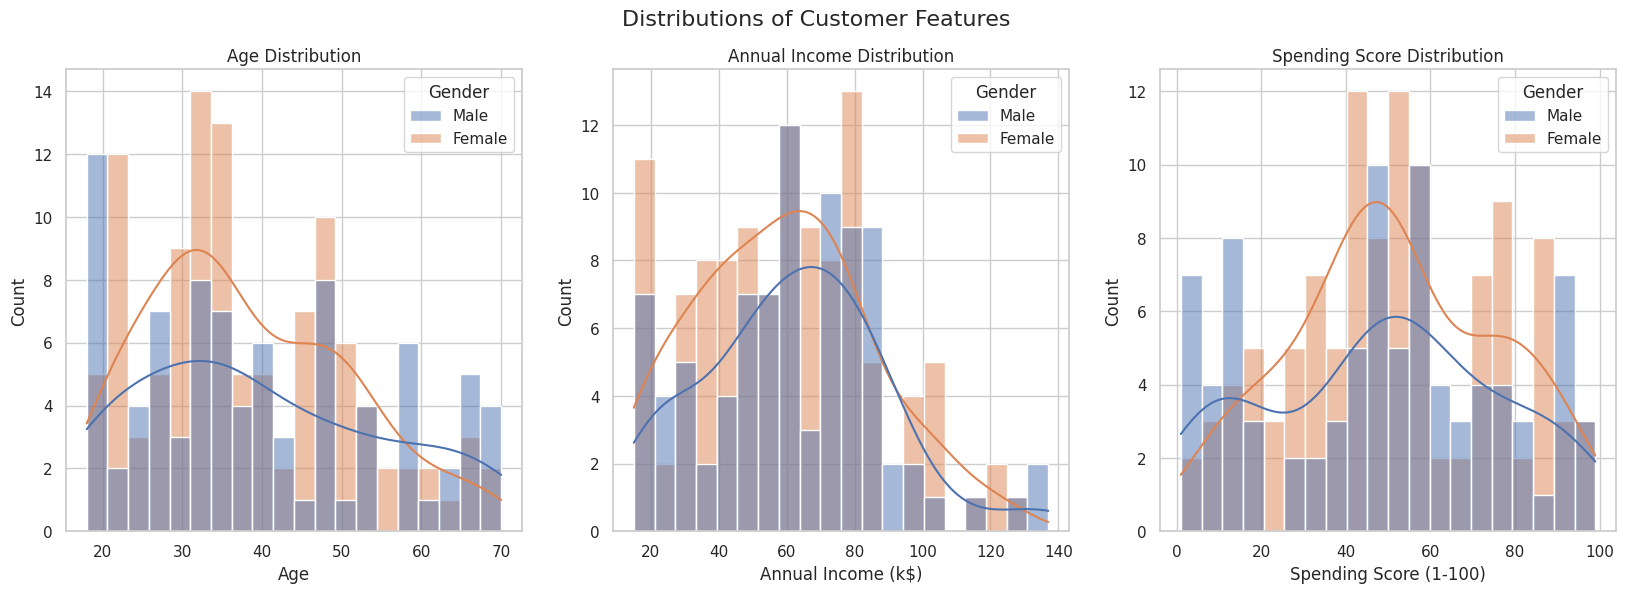

In [ ]:
# Univariate Analysis

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

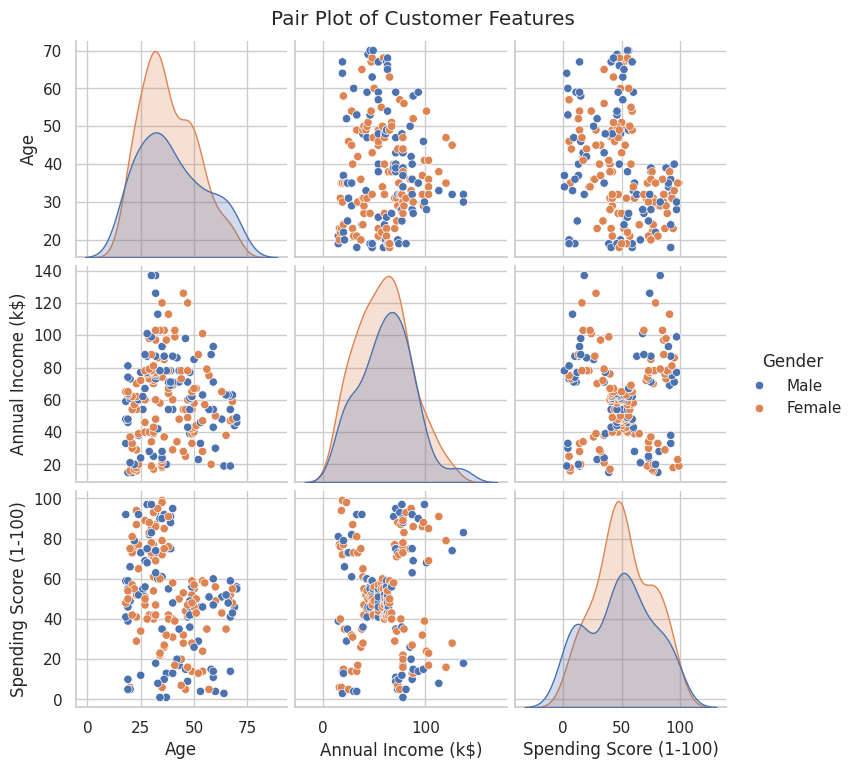

In [ ]:
# Bivariate Analysis

# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

**CRITICAL INSIGHT from Pair Plot:**
- The **`Annual Income` vs. `Spending Score`** plot is the most revealing. It clearly shows distinct, blob-like groups, making it the perfect candidate for clustering.
- The **`Age` vs. `Spending Score`** plot shows some patterns but they are less defined. We see a concentration of high-spending customers in the younger age brackets.
- `Gender` does not appear to be a strong separating factor in any of these plots, as the distributions for males and females largely overlap.

In [ ]:
# 3D Visualization
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

## **The Elbow Method**

How do we choose the best number of clusters (`k`) for our K-Means model? The **Elbow Method** is a common technique.

It works by calculating the **Within-Cluster Sum of Squares (WCSS)** for different values of `k` (typically from 1 to 10). WCSS is the sum of the squared distances between each point and the centroid of the cluster it belongs to. A lower WCSS means the points are closer to their cluster centroids, indicating tighter clusters.

We then plot WCSS against the number of clusters (`k`). As `k` increases, WCSS will always decrease (because each point gets closer to its assigned centroid). However, at some point, adding more clusters doesn't significantly reduce the WCSS. This point, where the rate of decrease sharply changes, looks like an "elbow" in the plot.

The **optimal number of clusters (`k`)** is typically chosen at this elbow point. It represents a good balance between having too few clusters (high WCSS) and too many clusters (overfitting and diminishing returns).

Here are the most common init options available:

* 'k-means++' (Default): This is the recommended method. It smarty initializes the centroids to be spread out from each other. This significantly improves the chances of finding a globally optimal solution and reduces the risk of converging to a suboptimal local minimum.
* 'random': This method chooses n_clusters observations (data points) randomly from the dataset and uses them as the initial centroids. While simple, it can sometimes lead to poor clustering results if the random initial centroids are not well-separated.
* A NumPy array: You can also provide a NumPy array with a shape of (n_clusters, n_features) that explicitly specifies the initial coordinates of the centroids. This is useful if you have prior knowledge about where the clusters should be located or if you want to replicate a specific initialization.

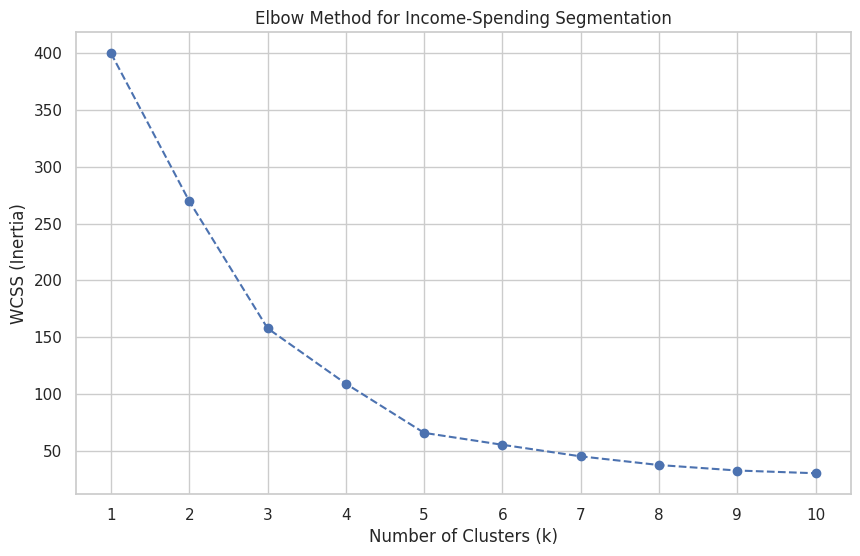

In [ ]:
# Segmentation Model 1- Income and Spending Score

# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

A low WCSS means that the points within each cluster are very close to their centroid. This suggests that the clusters are tight and well-defined.

A high WCSS means that the points within each cluster are more spread out from their centroid, indicating less distinct or looser clusters.

How WCSS relates to K-Means: In K-Means, the algorithm's goal is to minimize the WCSS. It tries to find the best locations for the centroids and the best groupings of points so that the total WCSS is as small as possible.

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [ ]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

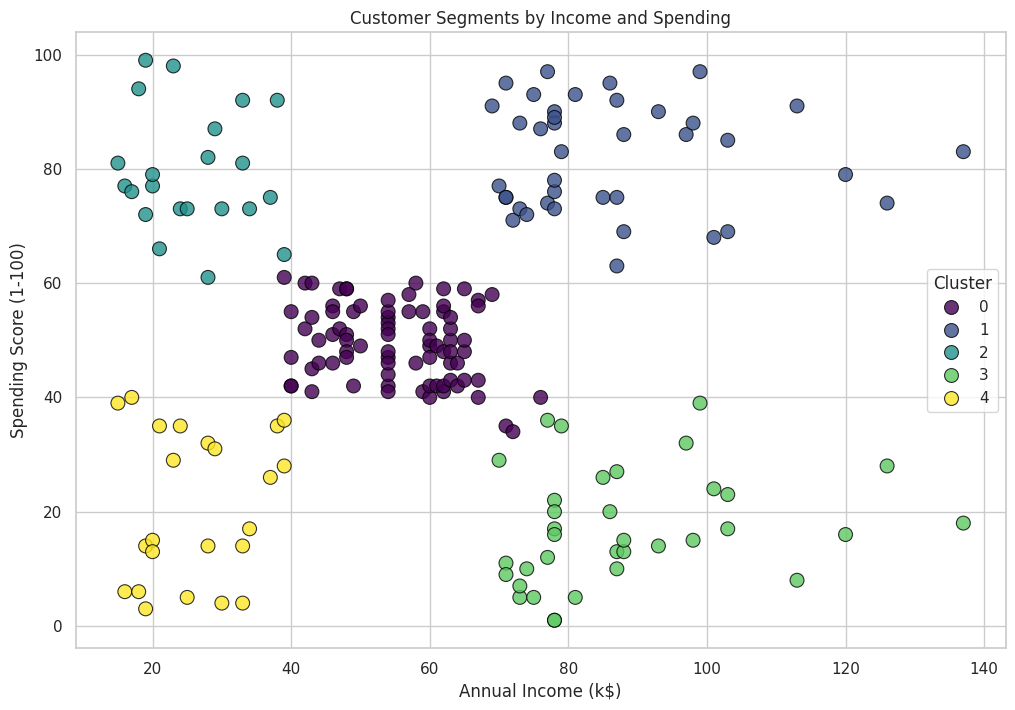

In [ ]:
# Visualizing and Interpreting the Income-Based Segments
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments:
- **Cluster 0 (Careful High-Earners):** High income (~88k) but low spending (\~17k). Cautious, value-driven buyers
- **Cluster 1 (Standard):** Average income (~55k) and spending (\~50k). This is the largest, core customer group.
- **Cluster 2 (Budget Shoppers):** Low income (~26k) and low spending (\~21k). Highly price-sensitive.
- **Cluster 3 (Target - High Value):** High income (~87k) and high spending (\~82k). The mall's prime target.
- **Cluster 4 (Enthusiasts):** Low income (~26k) but high spending (\~79k). Likely young, trend-focused shoppers.

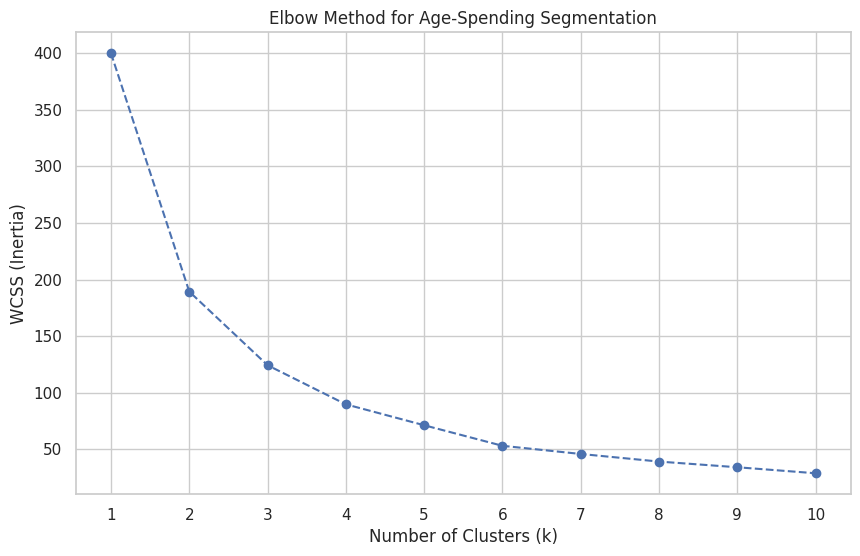

In [ ]:
# Segmentation Model 2- Age and Spending Score

# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

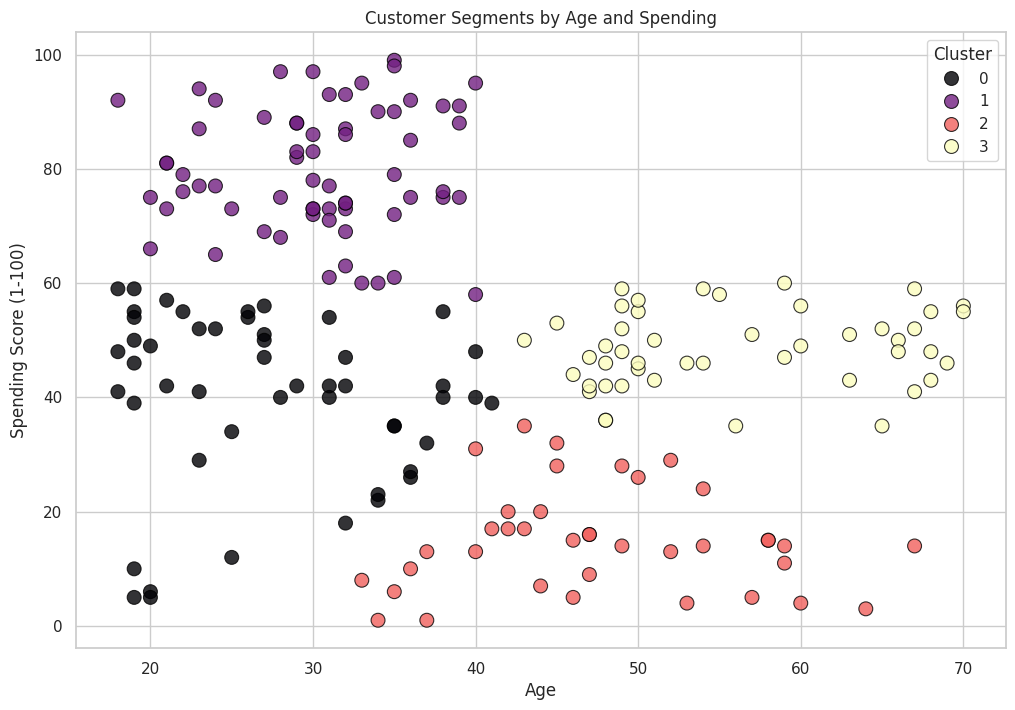

In [ ]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

#### **Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.

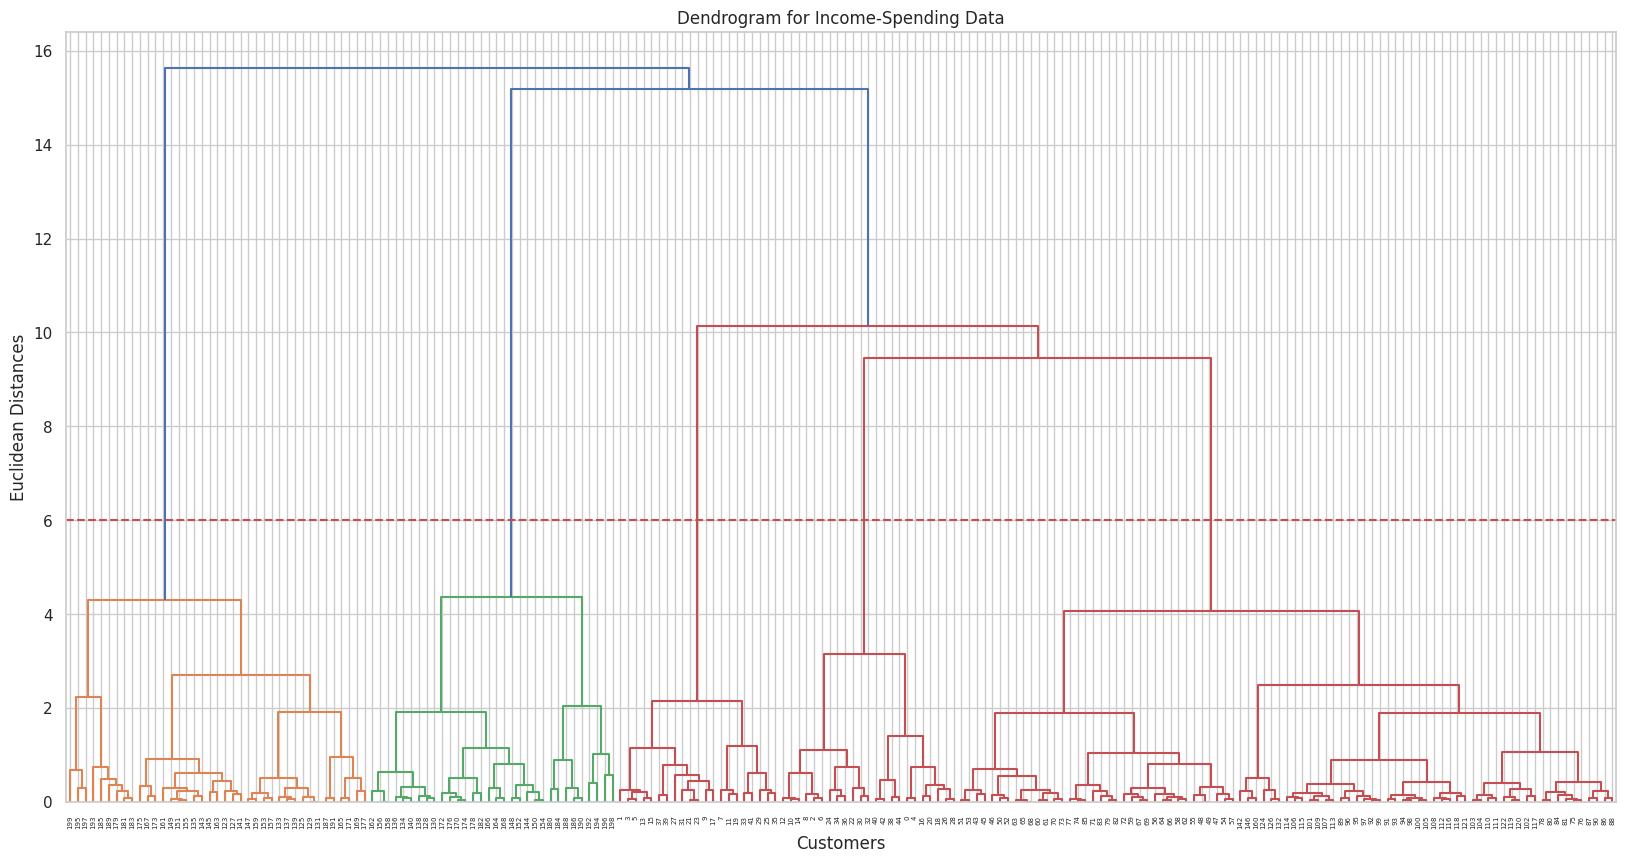

In [ ]:
# Alternative Method- Hierarchical Clustering

plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Conclusion

In this extended project, we successfully applied unsupervised machine learning to perform customer segmentation.

**Key Steps Undertaken:**
1.  **Performed an in-depth EDA:** Used 2D and 3D plots to explore customer data from multiple angles.
2.  **Built two distinct segmentation models:** Created an income-based model and an age-based model, showing that segmentation is not a one-size-fits-all process.
3.  **Used the Elbow Method** to programmatically determine the optimal number of clusters for each scenario.
4.  **Introduced Hierarchical Clustering** as an alternative method and used its dendrogram to validate our choice of `k`.
5.  **Created quantitative, data-driven personas** for each segment, providing the marketing team with precise, actionable insights for targeted campaigns.

This project highlights how different clustering approaches can uncover different facets of customer behavior, providing a richer, more nuanced understanding than a single model alone.

#**SUBMISSION**

**1. Explore Gender vs. Spending Score**

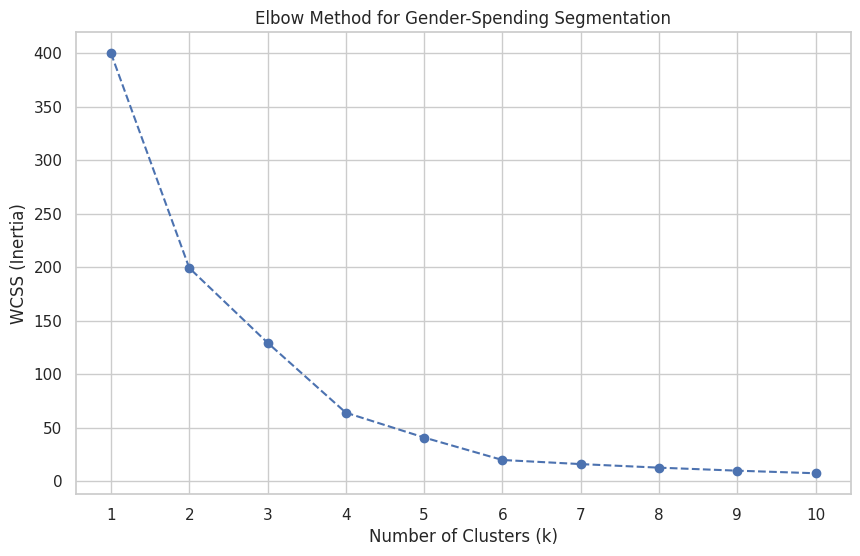

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode Gender
le = LabelEncoder()
df['Gender_encoded'] = le.fit_transform(df['Gender'])  # Male=1, Female=0

# 1. Select and scale the features
X3 = df[['Gender_encoded', 'Spending Score (1-100)']]
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

# 2. Implement the Elbow Method
wcss3 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    wcss3.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss3, marker='o', linestyle='--')
plt.title('Elbow Method for Gender-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** k=4 appears to be a reasonable choice

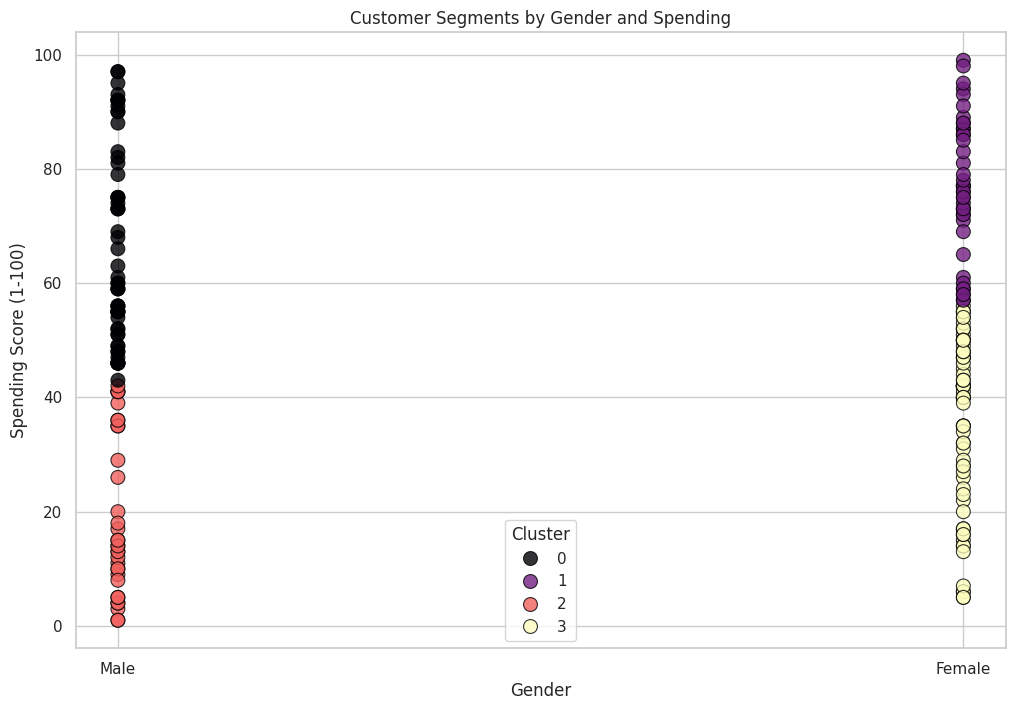

In [ ]:
# Build and fit the final model for age segmentation
kmeans3 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans3.fit_predict(X3_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Gender', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Gender and Spending')
plt.legend(title='Cluster')
plt.show()

####**Interpreting the Gender-Based Segments:**

* **High-Spending Males:** High spending scores (~40 to 100)
* **High-Spending Females:** High spending scores (~60 to 100)
* **Low-Spending Males:** Low spending scores (below ~40)
* **Low-Spending Females:** Low spending scores (below ~60)

**2. Apply Feature Engineering for Clustering**

In [ ]:
# Create New Feature 'Spending_Index'
df['Spending_Index'] = df['Spending Score (1-100)'] / df['Annual Income (k$)']

In [ ]:
X4 = df[['Annual Income (k$)', 'Spending_Index']]

scaler4 = StandardScaler()
X4_scaled = scaler4.fit_transform(X4)

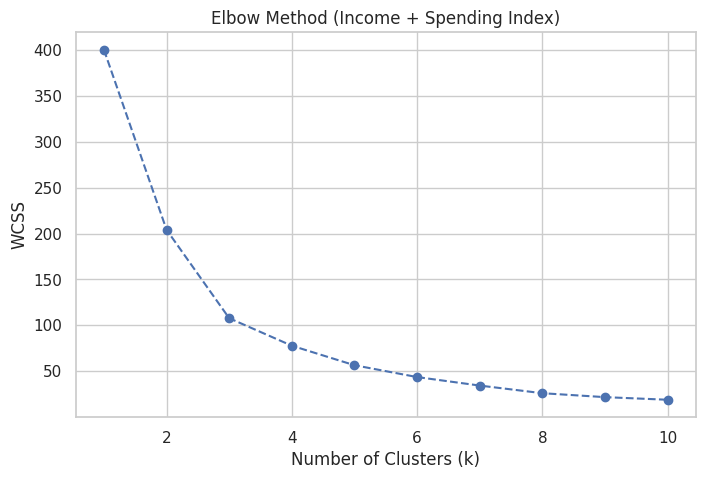

In [ ]:
wcss4 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X4_scaled)
    wcss4.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss4, marker='o', linestyle='--')
plt.title('Elbow Method (Income + Spending Index)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Observation:** k=4 appears to be a reasonable choice

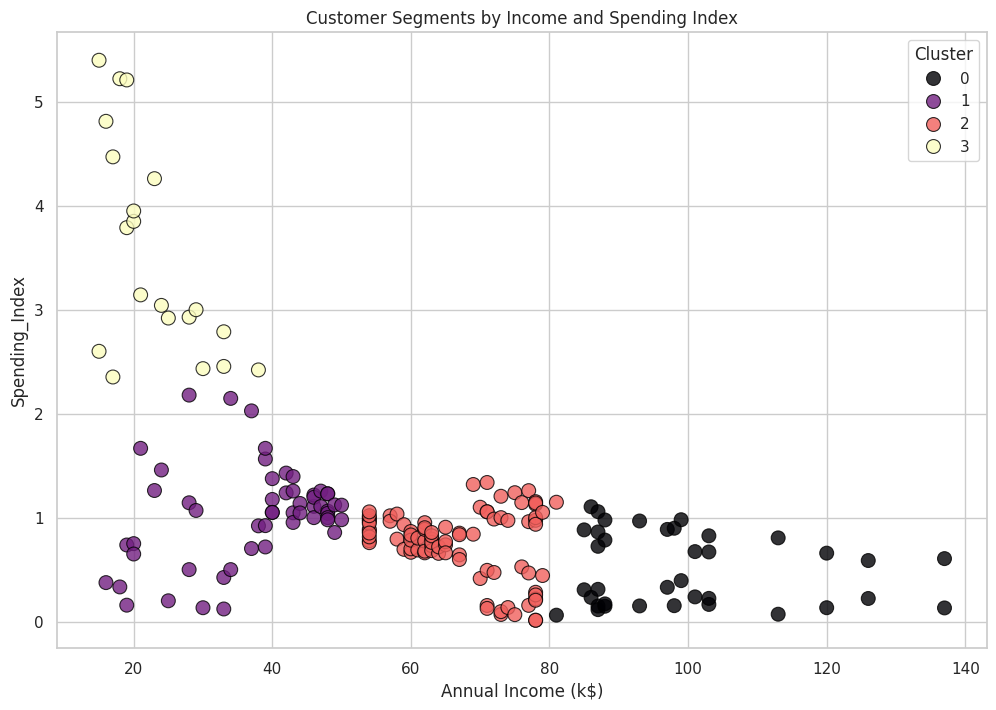

In [ ]:
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X4_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending_Index',
                hue='Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending Index')
plt.legend(title='Cluster')
plt.show()

####**Interpreting the Spending_Index-Based Segments:**

* **High-Income, Low Spending Index:** They earn more but spend very little  relative to their income.
* **Low Income, Low Spending index:** They earn less and spend less
* **Moderate Income, Low Spending Index:** They earn well but spend conservatively.
* **Low Income, High spending index:** They spend a lot despite lower incomes, they are impulsive buyers